In [ ]:
import pandas as pd
import numpy as np
import pickle
import torch
from torch import nn,optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
 
print(torch.__version__)
 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: {}'.format(device))
 
torch.manual_seed(777)
np.random.seed(777)

1.6.0+cu101
Device: cuda:0


In [ ]:
#read the data and prepare for ML
df = pd.read_csv("/content/drive/My Drive/SML Covid project/swabsdl_0718.csv.gz",
                 index_col=False, compression="gzip")

df

,Gender,Age,Risk_COPD,Risk_Diabetes,Risk_Immunosupr,Risk_Hypert,Risk_CRI,Risk_Obese,Risk_Asthma,Risk_Cardiov,Risk_Smoker,Deceased
0,Male,21,0,0,0,0,0,0,0,0,0,0
1,Male,23,0,0,0,0,0,0,0,0,0,0
2,Male,60,0,0,0,0,0,1,0,0,1,0
3,Female,48,0,0,0,1,0,0,0,0,0,0
4,Male,75,0,1,0,1,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
163661,Male,49,0,0,0,1,0,0,0,0,0,0
163662,Male,41,0,0,0,0,0,0,0,0,0,0
163663,Female,47,1,1,0,1,1,0,0,0,1,1
163664,Male,44,0,0,0,0,0,1,0,0,0,0


In [ ]:

#Risk_* -> NA=0
#df = df.fillna(0)
#df = df.dropna()


#gender -> 2 1-hot
df = pd.concat([pd.get_dummies(df["Gender"]),
                df["Age"]/max(df["Age"]),
                df.iloc[:,2:]],axis=1)

df.describe()

,Female,Male,Age,Risk_COPD,Risk_Diabetes,Risk_Immunosupr,Risk_Hypert,Risk_CRI,Risk_Obese,Risk_Asthma,Risk_Cardiov,Risk_Smoker,Deceased
count,163666.000000,163666.000000,163666.000000,163666.000000,163666.000000,163666.000000,163666.000000,163666.000000,163666.000000,163666.000000,163666.000000,163666.000000,163666.000000
mean,0.445969,0.554031,0.384133,0.018397,0.168538,0.014371,0.206078,0.022521,0.199308,0.027776,0.024526,0.079228,0.155878
std,0.497074,0.497074,0.134860,0.134383,0.374345,0.119014,0.404489,0.148372,0.399482,0.164331,0.154675,0.270096,0.362741
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.283333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.375000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.475000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
#random 80/20 train/test split
idxes = np.arange(len(df))
np.random.shuffle(idxes)

x = df.values[idxes,:-1].astype(np.float32)
y = df.values[idxes,-1].astype(np.float32)

input_size = x.shape[1]

idx_train = int(len(df)*.8)
x_train = x[:idx_train,:]
y_train = y[:idx_train]

x_test = x[idx_train:,:]
y_test = y[idx_train:]

# Check splits balance
np.set_printoptions(3,suppress=True)
print("Total:\n",np.mean(x,axis=0), x.shape, np.mean(y), y.shape,"\n",
      "Train:\n",np.mean(x_train,axis=0),x_train.shape,np.mean(y_train), y_train.shape,"\n",
      "Test:\n",np.mean(x_test,axis=0),x_test.shape,np.mean(y_test), y_test.shape)

#Custom Dataset for DataLoader
class MexicoCovid19Df(Dataset):
  def __init__(self, x, y):
    self.x = x
    self.y = y
  
  def __len__(self):
    return len(self.x)

  def __getitem__(self,iii):
    return (self.x[iii,:], self.y[iii])

Total:
 [0.446 0.554 0.384 0.018 0.169 0.014 0.206 0.023 0.199 0.028 0.025 0.079] (163666, 12) 0.15587844 (163666,) 
 Train:
 [0.446 0.554 0.384 0.018 0.168 0.015 0.206 0.022 0.201 0.028 0.024 0.079] (130932, 12) 0.15582134 (130932,) 
 Test:
 [0.447 0.553 0.385 0.019 0.17  0.013 0.208 0.024 0.194 0.028 0.025 0.08 ] (32734, 12) 0.1561068 (32734,)


In [ ]:
#Define the network
def MexicoFNN(hidden_arch,relu=False,input_size=input_size):
  layers = []
 
  #input
  layers.append(nn.Linear(input_size,hidden_arch[0]))
  if relu:
    layers.append(nn.ReLU())
  else:
    layers.append(nn.Tanh())
  #hidden according to arch
  for iii in range(1,len(hidden_arch)):
    layers.append(nn.Linear(hidden_arch[iii-1],hidden_arch[iii]))
    if relu:
      layers.append(nn.ReLU())
    else:
      layers.append(nn.Tanh())
  
  layers.append(nn.Linear(hidden_arch[-1], 1))
  layers.append(nn.Sigmoid())
  
  return nn.Sequential(*layers)

In [ ]:
#Network initialization
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

def compute_best_thresh(model,x,y,prec=10e-5):
  y_pred = model(x).cpu().detach().squeeze().numpy()
  y = y.cpu().detach().squeeze().numpy()
  
  t = .5
  eps = t/2
  sens = lambda t: sum(y_pred[y==1]>=t)/sum(y==1)
  acc = lambda t: sum((y_pred>=t) == (y==1))/len(y)
  val = lambda t: sens(t) - acc(t)
  valt = val(t)
  while (valt != 0) and (eps>prec):
    if valt<0:
      t = t-eps
    else:
      t= t+eps

    valt = val(t)
    eps/=2
  return t


#Compute metrics
def compute_metrics(model,loss,x,y,weight_fact=None,
                    class_threshs=None):
  
  if class_threshs == None:
    class_threshs = [.5,compute_best_thresh(model,x,y)]

  y_pred = model(x)
  if weight_fact:
    err = loss(y_pred,weight_fact*y).item()
  else:
    err = loss(y_pred,y).item()
  y = y.cpu().detach().squeeze().numpy()
  y_pred = y_pred.cpu().detach().squeeze().numpy()

  trs = {}

  for t in class_threshs:
    m = np.array([[sum(y_pred[y==0]<t),sum(y_pred[y==1]<t)],
                  [sum(y_pred[y==0]>=t),sum(y_pred[y==1]>=t)]])
    p = np.diag(m)/np.sum(m,1)
    r = np.diag(m)/np.sum(m,0)
    a = sum(np.diag(m))/np.sum(m)
    trs[t]={"confusion":m,"precisions":p,"recalls":r,"accuracy":a}

  return {"loss":err,"threshs":trs}

#Training algorithm
def trainNN(model, opti, loss,
            x_train=x_train, y_train=y_train,
            x_test=x_test, y_test=y_test,
            init_model_f = init_weights, init_opti_state = None,
            batch_size=100,
            best_ep_count=0,
            weight_fact = None,
            val_size = .3, patience=10, validate_every=5):

  #outputs
  outputs = {}

  #init opti (optional)
  if init_opti_state:
    opti.load_state_dict(init_opti_state)
  
  model.apply(init_model_f)

  #Evaluate best number of epoch using early stopping
  if best_ep_count <= 0:
    print("Computing best number of epochs with early stopping...")
    
    #save opti state if necessary
    if init_opti_state==None:
      init_opti_state = opti.state_dict()

    best_v_err = np.inf
    no_improvements=0

    #validation split
    idx_val = int(x_train.shape[0] * (1-val_size))
    dl_train = DataLoader(MexicoCovid19Df(x_train[:idx_val,:],y_train[:idx_val]),
                          batch_size, shuffle=True)
    
    x_val = torch.tensor(x_train[idx_val:,:],device=device)
    y_val = torch.tensor(y_train[idx_val:]).unsqueeze(1).to(device)

    print("Train samples:{} ({} batches of {}), Validation samples:{} ({}% of the training set)".format(
        idx_val, len(dl_train),batch_size,x_val.shape[0],int(val_size*100)))

    current_ep=0
    pretrain_errs = []
    val_errs = []
    train_err = 0
    while no_improvements<patience:

      #mini-batch train
      train_err = 0
      for batch in dl_train:
        outs = model(batch[0].to(device))
        batch_err = loss(outs,batch[1].unsqueeze(1).to(device))
        train_err += batch_err.item()

        opti.zero_grad()
        batch_err.backward()
        opti.step()

      train_err/=len(dl_train)
      #store errors for output
      pretrain_errs.append([current_ep,train_err])

      #estimate validation error, update no_improvements
      val_err = np.nan
      if (no_improvements>0) or ((current_ep % validate_every)==0): 
        y_pred = model(x_val)
        val_err = loss(y_pred,y_val).item()

        val_errs.append([current_ep,val_err])

        if (val_err<best_v_err):
          best_ep_count = current_ep
          best_v_err = val_err
          no_improvements=0
        else:
          no_improvements+=1

        print("Pre-Train: EP={} TrainErr={} ValErr={} ({} at ep {}) Patience left:{}".format(
            current_ep,train_err,val_err,best_v_err,best_ep_count, patience-no_improvements))
        

      current_ep +=1

    print("Pre-Train finished!\nBest no. epochs: ",best_ep_count,
          "( ValErr=",best_v_err,")")

    #store outputs
    outputs["pretrain"] = np.array(pretrain_errs)
    outputs["val"] = np.array(val_errs)

    #Reset model and opti
    opti.load_state_dict(init_opti_state)
    model.apply(init_model_f)
  else:
    print("Skipping best epoch count evaluation...")
  

  print("Beginning training. Total epochs: {}".format(best_ep_count))

  #train for given number of epochs on the full training set
  current_ep=0
  dl_train = DataLoader(MexicoCovid19Df(x_train,y_train),
                        batch_size, shuffle=True)
  print("Train samples:{} ({} batches of {})".format(
      x_train.shape[0], len(dl_train),batch_size))
  
  train_errs = []
  while current_ep <= best_ep_count:

    #mini-batch train
    train_err = 0
    for batch in dl_train:
      outs = model(batch[0].to(device))
      if weight_fact:
        batch_err = loss(outs,weight_fact* batch[1].unsqueeze(1).to(device))
      else:
        batch_err = loss(outs,batch[1].unsqueeze(1).to(device))
      train_err+= batch_err.item()

      opti.zero_grad()
      batch_err.backward()
      opti.step()

    train_err /= len(dl_train) 
    #store errors for output
    train_errs.append([current_ep,train_err])

    if (current_ep%5) ==0:
      print("Train: EP={}, TrainErr={}".format(current_ep, train_err))
    current_ep+=1

  print("Training ended on epoch",current_ep-1,
        " TrainErr=", train_err)
  
  outputs["train"] = np.array(train_errs)

  #estimate final train/test metrics
  print("Evaluating train/test metrics...")
  train_metrics = compute_metrics(model,loss,torch.Tensor(x_train).to(device),
                                  torch.Tensor(y_train).unsqueeze(1).to(device),
                                  weight_fact)
  test_metrics = compute_metrics(model,loss,torch.Tensor(x_test).to(device),
                                 torch.Tensor(y_test).unsqueeze(1).to(device),
                                 weight_fact)
  
  outputs["metrics"] = {"train":train_metrics, "test":test_metrics}

  print("======RESULTS======")
  for n in outputs["metrics"]:
    e = outputs["metrics"][n]["loss"]
    print("-{}- Loss:{}".format(n,e))
    for t in outputs["metrics"][n]["threshs"]:
      m,p,r,a = outputs["metrics"][n]["threshs"][t].values()
      print("[thresh {}]\n Confusion matrix:\n {}\n Prec {}\n Rec {}\n Acc {}".format(t,m,p,r,a))

  return outputs
def model_summary(output):
  ptrain = output["pretrain"]
  val = output["val"]
  train = output["train"]

  fig, ax = plt.subplots()
  
  ax.plot(ptrain[1:,0],ptrain[1:,1],label="Pre-train error")
  ax.plot(val[1:,0],val[1:,1],label="Validation error")
  ax.plot(train[1:,0],train[1:,1],label="Train error")
  ax.axvline(train[-1,0],ls='--',color="grey")
  ax.set_xlabel("Epochs")
  ax.set_ylabel("BCE")
  ax.legend()
  
  testmet = output["metrics"]["test"]
  best_t = list(testmet["threshs"].keys())[1]
  print("Test loss:\t{}\nBest thresh:\t{}\nAccuracy @ t:\t{}\nSens @ t:\t{}\n{}".format(
      testmet["loss"],
      best_t,
      testmet["threshs"][best_t]["accuracy"],
      testmet["threshs"][best_t]["recalls"][1],
      testmet["threshs"][best_t]["confusion"]))
  plt.show()

def save_plot(output,fname="fig",title=None,dpi=90):
  ptrain = output["pretrain"]
  val = output["val"]
  train = output["train"]

  fig, ax = plt.subplots()
  ax.plot(ptrain[1:,0],ptrain[1:,1],label="Pre-train error")
  ax.plot(val[1:,0],val[1:,1],label="Validation error")
  ax.plot(train[1:,0],train[1:,1],label="Train error")
  ax.axvline(train[-1,0],ls='--',color="grey")
  ax.set_xlabel("Epochs")
  ax.set_ylabel("BCE")
  if (title!=None):
    plt.title(title)
  ax.legend()

  #plt.show()
  plt.savefig(fname, dpi=dpi)

In [ ]:
#Train models
outs_adam = {}
for i,arch in [#["xxs",[2]],
               ["s",[input_size//2]],
               ["m",[input_size//2,input_size//4]],
               ["l",[input_size//2,input_size//2,input_size//4]]]:
               #["xl",[input_size,input_size,input_size,2]]]:
  #for j,acti in [["relu",True],["tanh",False]]:
  fnn = MexicoFNN(arch,False)
  fnn.to(device)
  print(fnn)

  #opti = optim.SGD(fnn.parameters(), lr=0.001, momentum=0.5)
  #opti = optim.Adagrad(fnn.parameters())
  opti = optim.Adam(fnn.parameters())
  loss = nn.BCELoss()

  out = trainNN(fnn,opti,loss,patience=20)
  outs_adam[i] = out

Sequential(
  (0): Linear(in_features=12, out_features=6, bias=True)
  (1): Tanh()
  (2): Linear(in_features=6, out_features=1, bias=True)
  (3): Sigmoid()
)
Computing best number of epochs with early stopping...
Train samples:91652 (917 batches of 100), Validation samples:39280 (30% of the training set)
Pre-Train: EP=0 TrainErr=0.4798094651528767 ValErr=0.402756005525589 (0.402756005525589 at ep 0) Patience left:20
Pre-Train: EP=5 TrainErr=0.33809987961790944 ValErr=0.33969801664352417 (0.33969801664352417 at ep 5) Patience left:20
Pre-Train: EP=10 TrainErr=0.3370317850046615 ValErr=0.3390669822692871 (0.3390669822692871 at ep 10) Patience left:20
Pre-Train: EP=15 TrainErr=0.3365815674140643 ValErr=0.3385496735572815 (0.3385496735572815 at ep 15) Patience left:20
Pre-Train: EP=20 TrainErr=0.3362570170195308 ValErr=0.33791592717170715 (0.33791592717170715 at ep 20) Patience left:20
Pre-Train: EP=25 TrainErr=0.33587393059010334 ValErr=0.3380931317806244 (0.33791592717170715 at ep 20) Pa

---s---
Test loss:	0.3390202224254608
Best thresh:	0.1966552734375
Accuracy @ t:	0.7511150485733488
Sens @ t:	0.7422700587084149
[[20794  1317]
 [ 6830  3793]]


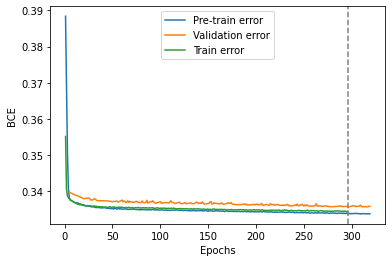

---m---
Test loss:	0.3396078944206238
Best thresh:	0.1641845703125
Accuracy @ t:	0.752306470336653
Sens @ t:	0.7432485322896282
[[20828  1312]
 [ 6796  3798]]


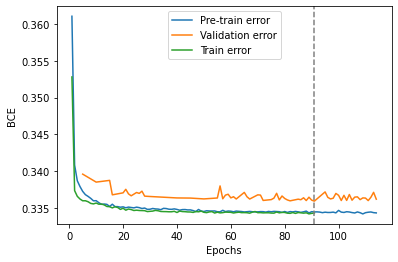

---l---
Test loss:	0.3385329246520996
Best thresh:	0.1822509765625
Accuracy @ t:	0.7516343862650455
Sens @ t:	0.7469667318982387
[[20787  1293]
 [ 6837  3817]]


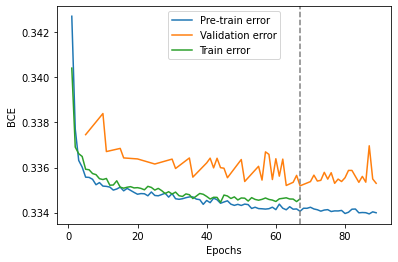

In [ ]:
for mkey in outs_adam.keys():
  print("---{}---".format(mkey))
  model_summary(outs_adam[mkey])

In [ ]:
#recompute metrics
mts = compute_metrics(fnn,loss,
                torch.Tensor(x).to(device),
                torch.Tensor(y).unsqueeze(1).to(device))
for t in mts["threshs"]:
  m,p,r,a =mts["threshs"][t].values()
  print("t:{}\n {}\n p:{}\n r:{}\n a:{}".format(t,m,p,r,a))

t:0.5
 [[134204  20735]
 [  3950   4777]]
 p:[0.866 0.547]
 r:[0.971 0.187]
 a:0.8491745383891585
t:0.1851806640625
 [[103389   6168]
 [ 34765  19344]]
 p:[0.944 0.358]
 r:[0.748 0.758]
 a:0.7498991849253969


In [ ]:
for mkey in outs.keys():
  print("---{}---".format(mkey))
  model_summary(outs[mkey])

NameError: ignored

In [ ]:
#let's try relu

outs2 = {}
for i,arch in [["s",[input_size//2]],
               ["m",[input_size//2,input_size//4]],
               ["l",[input_size//2,input_size//2,input_size//4]]]:
  fnn = MexicoFNN(arch,True)
  fnn.to(device)
  print(fnn)

  opti = optim.Adam(fnn.parameters())

  out = trainNN(fnn,opti,loss,patience=20)
  outs2[i] = out

Sequential(
  (0): Linear(in_features=12, out_features=6, bias=True)
  (1): ReLU()
  (2): Linear(in_features=6, out_features=1, bias=True)
  (3): Sigmoid()
)
Computing best number of epochs with early stopping...
Train samples:91652 (917 batches of 100), Validation samples:39280 (30% of the training set)
Pre-Train: EP=0 TrainErr=0.4427807153636263 ValErr=0.38728103041648865 (0.38728103041648865 at ep 0) Patience left:20
Pre-Train: EP=5 TrainErr=0.3370958346316963 ValErr=0.3386956453323364 (0.3386956453323364 at ep 5) Patience left:20
Pre-Train: EP=10 TrainErr=0.3359203096986987 ValErr=0.3381103575229645 (0.3381103575229645 at ep 10) Patience left:20
Pre-Train: EP=15 TrainErr=0.3354946577854479 ValErr=0.3378191888332367 (0.3378191888332367 at ep 15) Patience left:20
Pre-Train: EP=20 TrainErr=0.3353581563727026 ValErr=0.337542861700058 (0.337542861700058 at ep 20) Patience left:20
Pre-Train: EP=25 TrainErr=0.3352319330562032 ValErr=0.33713722229003906 (0.33713722229003906 at ep 25) Patie

---s---
Test loss:	0.3393057584762573
Best thresh:	0.2005615234375
Accuracy @ t:	0.7529174558562962
Sens @ t:	0.7454011741682974
[[20837  1301]
 [ 6787  3809]]


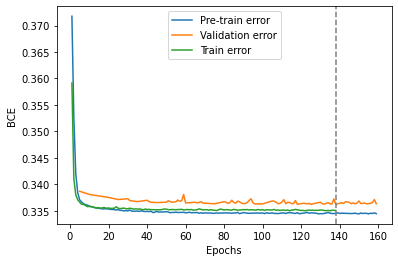

---m---
Test loss:	0.33932384848594666
Best thresh:	0.1851806640625
Accuracy @ t:	0.750198570293884
Sens @ t:	0.7450097847358121
[[20750  1303]
 [ 6874  3807]]


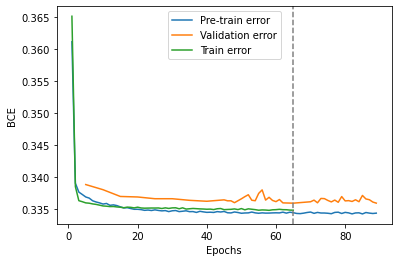

---l---
Test loss:	0.3398154079914093
Best thresh:	0.1680908203125
Accuracy @ t:	0.7478768253192399
Sens @ t:	0.7467710371819961
[[20665  1294]
 [ 6959  3816]]


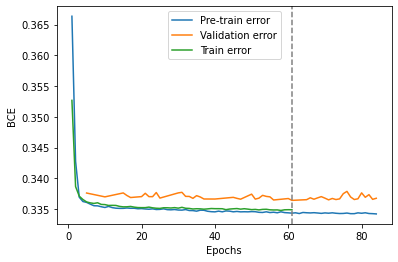

In [ ]:
for mkey in outs2.keys():
  print("---{}---".format(mkey))
  model_summary(outs2[mkey])
  #save_plot(outs2[mkey],mkey)

In [ ]:
#relu -> s, tanh -> m
# vary number of nodes
# extend patience

outs3 = {}
for i,arch in [["relu_xs",[input_size//3]],
               ["relu_sm",[(2*input_size)//3]]]:
  fnn = MexicoFNN(arch,True)
  fnn.to(device)
  print(fnn)

  opti = optim.Adam(fnn.parameters())

  out = trainNN(fnn,opti,loss,patience=30)
  outs3[i] = out
for i,arch in [["tanh_ms",[input_size//3,input_size//6]],
               ["tanh_ml",[(2*input_size)//3,input_size//3]]]:
  fnn = MexicoFNN(arch,False)
  fnn.to(device)
  print(fnn)

  opti = optim.Adam(fnn.parameters())

  out = trainNN(fnn,opti,loss,patience=30)
  outs3[i] = out

Sequential(
  (0): Linear(in_features=12, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=1, bias=True)
  (3): Sigmoid()
)
Computing best number of epochs with early stopping...
Train samples:91652 (917 batches of 100), Validation samples:39280 (30% of the training set)
Pre-Train: EP=0 TrainErr=0.4673968658192467 ValErr=0.39910271763801575 (0.39910271763801575 at ep 0) Patience left:30
Pre-Train: EP=5 TrainErr=0.33791947540306083 ValErr=0.33876118063926697 (0.33876118063926697 at ep 5) Patience left:30
Pre-Train: EP=10 TrainErr=0.3361772839609643 ValErr=0.33793237805366516 (0.33793237805366516 at ep 10) Patience left:30
Pre-Train: EP=15 TrainErr=0.33580741008404424 ValErr=0.33802175521850586 (0.33793237805366516 at ep 10) Patience left:29
Pre-Train: EP=16 TrainErr=0.33582492418091586 ValErr=0.33739742636680603 (0.33739742636680603 at ep 16) Patience left:30
Pre-Train: EP=20 TrainErr=0.33564968668777523 ValErr=0.33792802691459656 (0.33739742636680603 a

---relu_xs---
Test loss:	0.3399573564529419
Best thresh:	0.1929931640625
Accuracy @ t:	0.7497097818781695
Sens @ t:	0.7499021526418786
[[20709  1278]
 [ 6915  3832]]


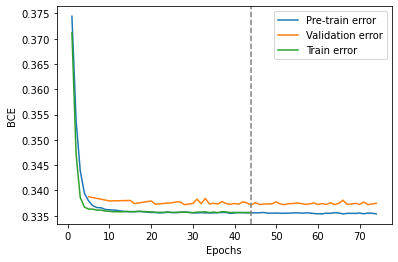

---relu_sm---
Test loss:	0.33897924423217773
Best thresh:	0.1964111328125
Accuracy @ t:	0.7502596688458484
Sens @ t:	0.7495107632093934
[[20729  1280]
 [ 6895  3830]]


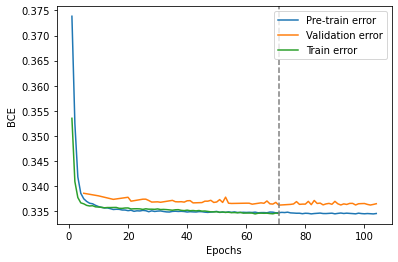

---tanh_ms---
Test loss:	0.3394547700881958
Best thresh:	0.1846923828125
Accuracy @ t:	0.7508706543654915
Sens @ t:	0.7487279843444227
[[20753  1284]
 [ 6871  3826]]


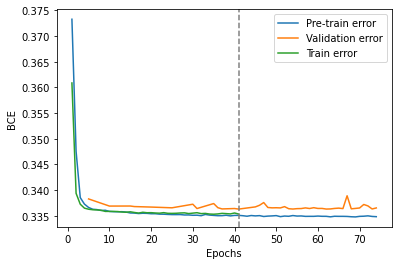

---tanh_ml---
Test loss:	0.3382214307785034
Best thresh:	0.1856689453125
Accuracy @ t:	0.749220993462455
Sens @ t:	0.7491193737769081
[[20697  1282]
 [ 6927  3828]]


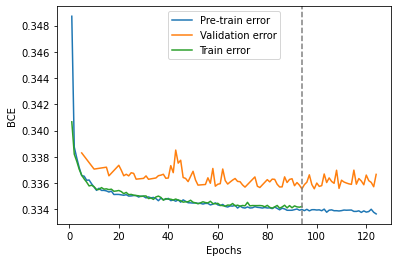

In [ ]:
for mkey in outs3.keys():
  print("---{}---".format(mkey))
  model_summary(outs3[mkey])

In [ ]:
outs4 = {}
#relu
for i,arch in [["relu_s",[input_size//2]],
               ["relu_sm",[(2*input_size)//3]]]:
  fnn = MexicoFNN(arch,True)
  fnn.to(device)
  print(fnn)

  opti = optim.Adam(fnn.parameters(),)
  loss = nn.BCELoss()

  out = trainNN(fnn,opti,loss,patience=40)
  outs4[i] = out
#tanh
for i,arch in [["tanh_m",[input_size//2,input_size//4]],
               ["tanh_ms",[input_size//3,input_size//6]]]:
  fnn = MexicoFNN(arch,False)
  fnn.to(device)
  print(fnn)

  opti = optim.Adam(fnn.parameters(),)
  loss = nn.BCELoss()

  out = trainNN(fnn,opti,loss,patience=40)
  outs4[i] = out

Sequential(
  (0): Linear(in_features=12, out_features=6, bias=True)
  (1): ReLU()
  (2): Linear(in_features=6, out_features=1, bias=True)
  (3): Sigmoid()
)
Computing best number of epochs with early stopping...
Train samples:91652 (917 batches of 100), Validation samples:39280 (30% of the training set)
Pre-Train: EP=0 TrainErr=0.4538976376553268 ValErr=0.38381829857826233 (0.38381829857826233 at ep 0) Patience left:40
Pre-Train: EP=5 TrainErr=0.33640568018479594 ValErr=0.33866047859191895 (0.33866047859191895 at ep 5) Patience left:40
Pre-Train: EP=10 TrainErr=0.33510583431146135 ValErr=0.33724918961524963 (0.33724918961524963 at ep 10) Patience left:40
Pre-Train: EP=15 TrainErr=0.3350868111185835 ValErr=0.33670613169670105 (0.33670613169670105 at ep 15) Patience left:40
Pre-Train: EP=20 TrainErr=0.33489979314440077 ValErr=0.3366576135158539 (0.3366576135158539 at ep 20) Patience left:40
Pre-Train: EP=25 TrainErr=0.33493666363841446 ValErr=0.3366713523864746 (0.3366576135158539 at ep

---relu_s---
Test loss:	0.33924365043640137
Best thresh:	0.1932373046875
Accuracy @ t:	0.7521537239567422
Sens @ t:	0.7440313111545989
[[20819  1308]
 [ 6805  3802]]


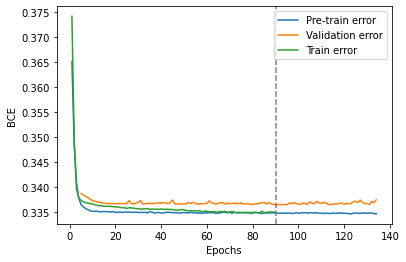

---relu_sm---
Test loss:	0.3395855724811554
Best thresh:	0.1951904296875
Accuracy @ t:	0.7495875847742408
Sens @ t:	0.7495107632093934
[[20707  1280]
 [ 6917  3830]]


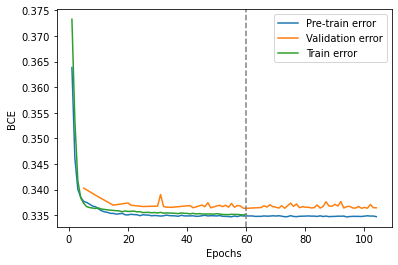

---tanh_m---
Test loss:	0.3391265571117401
Best thresh:	0.1878662109375
Accuracy @ t:	0.7504429645017413
Sens @ t:	0.7497064579256361
[[20734  1279]
 [ 6890  3831]]


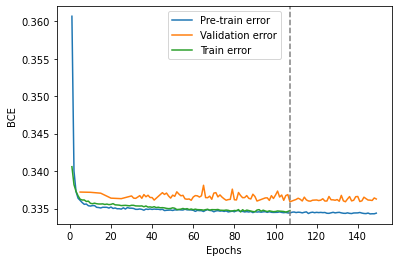

---tanh_ms---
Test loss:	0.339496374130249
Best thresh:	0.1973876953125
Accuracy @ t:	0.7491598949104906
Sens @ t:	0.7493150684931507
[[20694  1281]
 [ 6930  3829]]


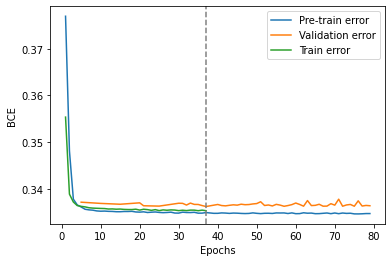

In [ ]:
for mkey in outs4.keys():
  print("---{}---".format(mkey))
  model_summary(outs4[mkey])

In [ ]:
# data without asthma, cardiov and smoker
x2_train = x_train[:,:-3]
x2_test = x_test[:,:-3]

input_size2 = x2_train.shape[1]

# Check splits balance
np.set_printoptions(3,suppress=True)
print("Total:\n",np.mean(x[:,:-3],axis=0), x[:,:-3].shape, np.mean(y), y.shape,"\n",
      "Train2:\n",np.mean(x2_train,axis=0),x2_train.shape,np.mean(y_train), y_train.shape,"\n",
      "Test:\n",np.mean(x2_test,axis=0),x2_test.shape,np.mean(y_test), y_test.shape)

Total:
 [0.446 0.554 0.384 0.018 0.169 0.014 0.206 0.023 0.199] (163666, 9) 0.15587844 (163666,) 
 Train2:
 [0.446 0.554 0.384 0.018 0.168 0.015 0.206 0.022 0.201] (130932, 9) 0.15582134 (130932,) 
 Test:
 [0.447 0.553 0.385 0.019 0.17  0.013 0.208 0.024 0.194] (32734, 9) 0.1561068 (32734,)


In [ ]:
outs5 = {}
#relu
for i,arch in [["relu_s2",[input_size2//2]],
               ["relu_sm2",[(2*input_size2)//3]]]:
  fnn = MexicoFNN(arch,True,input_size2)
  fnn.to(device)
  print(fnn)

  opti = optim.Adam(fnn.parameters(),)
  loss = nn.BCELoss()

  out = trainNN(fnn,opti,loss,patience=40,
                x_train=x2_train,
                x_test=x2_test)
  outs5[i] = out
#tanh
for i,arch in [["tanh_m2",[input_size2//2,input_size2//4]],
               ["tanh_ms2",[input_size2//3,input_size2//6]]]:
  fnn = MexicoFNN(arch,False,input_size2)
  fnn.to(device)
  print(fnn)

  opti = optim.Adam(fnn.parameters(),)
  loss = nn.BCELoss()

  
  out = trainNN(fnn,opti,loss,patience=40,
                x_train=x2_train,
                x_test=x2_test)
  outs5[i] = out

Sequential(
  (0): Linear(in_features=9, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=1, bias=True)
  (3): Sigmoid()
)
Computing best number of epochs with early stopping...
Train samples:91652 (917 batches of 100), Validation samples:39280 (30% of the training set)
Pre-Train: EP=0 TrainErr=0.431955639902612 ValErr=0.4006999731063843 (0.4006999731063843 at ep 0) Patience left:40
Pre-Train: EP=5 TrainErr=0.3390537204795731 ValErr=0.34015294909477234 (0.34015294909477234 at ep 5) Patience left:40
Pre-Train: EP=10 TrainErr=0.33609102841876975 ValErr=0.33796262741088867 (0.33796262741088867 at ep 10) Patience left:40
Pre-Train: EP=15 TrainErr=0.33583528656540934 ValErr=0.33778661489486694 (0.33778661489486694 at ep 15) Patience left:40
Pre-Train: EP=20 TrainErr=0.3358074194764883 ValErr=0.33753788471221924 (0.33753788471221924 at ep 20) Patience left:40
Pre-Train: EP=25 TrainErr=0.3357625341727403 ValErr=0.3383359909057617 (0.33753788471221924 at ep 20

---relu_s2---
Test loss:	0.3388713598251343
Best thresh:	0.2000732421875
Accuracy @ t:	0.7497708804301338
Sens @ t:	0.7475538160469667
[[20723  1290]
 [ 6901  3820]]


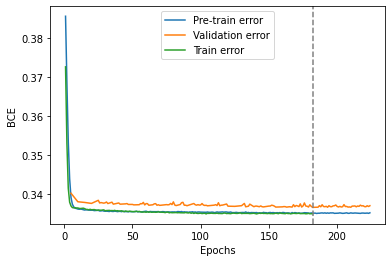

---relu_sm2---
Test loss:	0.33975937962532043
Best thresh:	0.1871337890625
Accuracy @ t:	0.7496792326021873
Sens @ t:	0.7489236790606654
[[20713  1283]
 [ 6911  3827]]


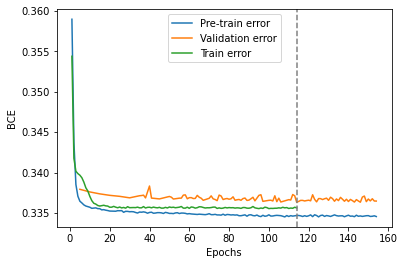

---tanh_m2---
Test loss:	0.3394022285938263
Best thresh:	0.1849365234375
Accuracy @ t:	0.750198570293884
Sens @ t:	0.7455968688845401
[[20747  1300]
 [ 6877  3810]]


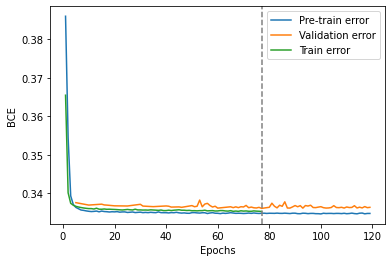

---tanh_ms2---
Test loss:	0.3388825058937073
Best thresh:	0.1885986328125
Accuracy @ t:	0.749618134050223
Sens @ t:	0.7499021526418786
[[20706  1278]
 [ 6918  3832]]


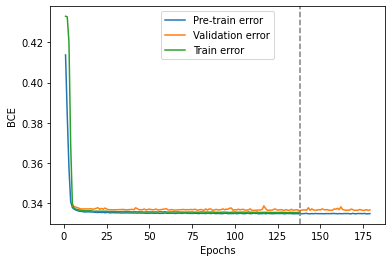

In [ ]:
for mkey in outs5.keys():
  print("---{}---".format(mkey))
  model_summary(outs5[mkey])

In [ ]:
#save outputs
with open("/content/drive/My Drive/SML Covid project/outs_tanh.pickle","wb") as f:
  pickle.dump(outs_adam,f)
with open("/content/drive/My Drive/SML Covid project/outs_relu.pickle","wb") as f:
  pickle.dump(outs2,f)
with open("/content/drive/My Drive/SML Covid project/outs_variations.pickle","wb") as f:
  pickle.dump(outs3,f)
with open("/content/drive/My Drive/SML Covid project/outs_finalfull.pickle","wb") as f:
  pickle.dump(outs4,f)
with open("/content/drive/My Drive/SML Covid project/outs_final9.pickle","wb") as f:
  pickle.dump(outs5,f)

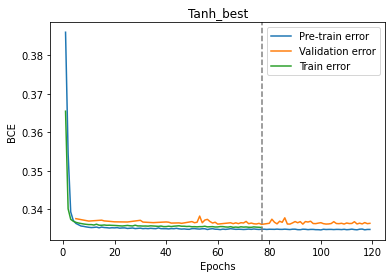

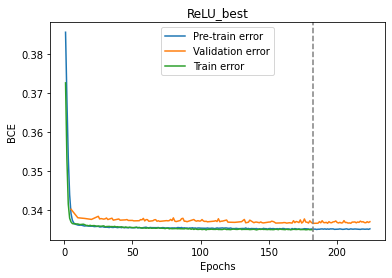

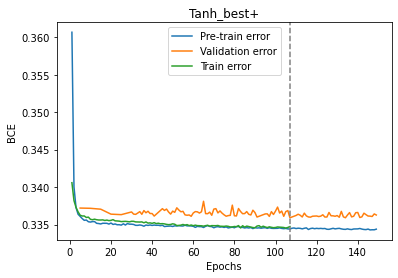

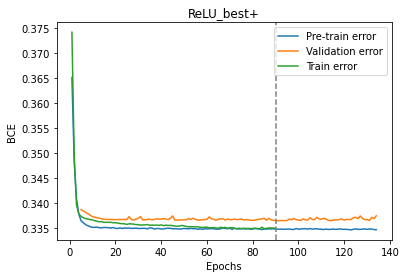

In [ ]:
#save final plots
save_plot(outs5["tanh_m2"],"/content/drive/My Drive/SML Covid project/tanh_m2_train.png",
          title="Tanh_best",dpi=180)
save_plot(outs5["relu_s2"],"/content/drive/My Drive/SML Covid project/relu_s2_train.png",
          title="ReLU_best",dpi=180)
save_plot(outs4["tanh_m"],"/content/drive/My Drive/SML Covid project/tanh_m_train.png",
          title="Tanh_best+",dpi=180)
save_plot(outs4["relu_s"],"/content/drive/My Drive/SML Covid project/relu_s_train.png",
          title="ReLU_best+",dpi=180)
